In [1]:
from tsai.all import *
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
import matplotlib
from sklearn.pipeline import make_pipeline
import joblib

In [2]:
def _model(X_train, X_test, y_train, y_test, epoch):
    X, y, splits = combine_split_data([X_train, X_test], [y_train.ravel(), y_test.ravel()])
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    
    ###fit
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=TSStandardize(by_var=True))
    model = TST(dls.vars, dls.c, dls.len, dropout=0.4, fc_dropout=0.9)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=accuracy,  cbs=ShowGraphCallback2())
    learn.fit_one_cycle(epoch, 1e-4)
    
    
    
    acc, f1 = calculate_acc_f1(learn, X_test, y_test)
    return learn, acc, f1


def calculate_acc_f1(learn, X_test, y_test):
    probas, target, preds = learn.get_X_preds(X_test, y_test.ravel(), with_decoded = True)
    k = torch.argmax(probas, dim = 1)
    acc = accuracy_score(y_test.ravel(), k.tolist())
    f1 = f1_score(y_test.ravel(), k.tolist(), average='weighted')
    return acc, f1

(22880, 1)


epoch,train_loss,valid_loss,accuracy,time
0,2.076386,1.954596,0.377797,06:11


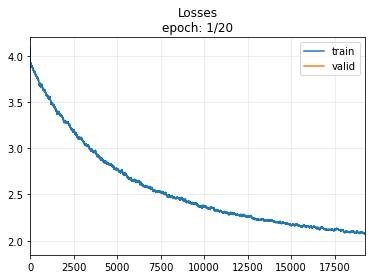

In [ ]:
base_path = "UnifiedSense/np_data"
folders = ["/ring2glass/", "/ring2headphone/", "/ring2watch/", "/watch2glass/", "/watch2headphone/"]
N = 12
epoch = 20
total_acc = 0
total_f1 = 0
final_record_acc = []
final_record_f1 = []
max_accuracy = 0
for k in range(N-1, N):
    record_acc = []
    record_f1 = []
    test_data = np.load("data_dump/"+"LOO_ALL_TEST_DATA"+str(k+1)+".npy", mmap_mode='c')
    test_label = np.load("data_dump/"+"LOO_ALL_TEST_LABEL"+str(k+1)+".npy", mmap_mode='c')
    train_data = np.load("data_dump/"+"LOO_ALL_TRAIN_DATA"+str(k+1)+".npy", mmap_mode='c')
    train_label = np.load("data_dump/"+"LOO_ALL_TRAIN_LABEL"+str(k+1)+".npy", mmap_mode='c')
    
#     [0.001, 0.002, 0.008, 0.02,  0.04, 0.07, 0.1, 0.2]
    for m in [0.25]:
        big_test, small_test, big_label, small_label = train_test_split(test_data, test_label, test_size=m, random_state=42, shuffle=True)
        
        print(small_label.shape)
        X_f = np.vstack((train_data, small_test))
        y_f = np.vstack((train_label, small_label))
        m_model, acc, f1  = _model(X_f, big_test, y_f, big_label, epoch)
        record_acc.append(acc)
        record_f1.append(f1)
    
    final_record_acc.append(record_acc)
    final_record_f1.append(record_f1)
    acc = sum(record_acc) / len(record_acc)
    f1 = sum(record_f1) / len(record_f1)
    print("Accuracy for participant ", N ,"is: ", acc, " and f1: ", f1)
    if max_accuracy > acc:
        max_accuracy = acc
    total_acc += acc
    total_f1 += f1
print("Leave one out avg. accuracy is: ", total_acc/N, " F1 is: ", total_f1/N)       
print("\n\n")
print(final_record_acc)
print(final_record_f1)

In [ ]:

acc = sum(record_acc) / len(record_acc)
f1 = sum(record_f1) / len(record_f1)
print("Accuracy for participant ", N ,"is: ", acc, " and f1: ", f1)
if max_accuracy > acc:
    max_accuracy = acc
total_acc += acc
total_f1 += f1
print("Leave one out avg. accuracy is: ", total_acc/N, " F1 is: ", total_f1/N)
print("\n\n")
print(final_record_acc)
print(final_record_f1)

In [ ]:
m_model.export("models/tst_loo6_"+str(N)+"_7.pkl")

In [ ]:
beep()